## Medical Appointment No Shows

### 1. Load Libraries

Below we will load all the required libraries. Libraries for reading CSV File, Basic EDA, Visualization and Data Modeling are all loaded in the below cell.

In [1]:
import pandas as pd
import numpy as np
import datetime
from time import strftime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
week_key = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

### 2. Load Data

In the below cell we will load the data from the CSV file in to a DataFrame. We will also check the row and column count by getting the shape of the data.

In [3]:
df = pd.read_csv('noshowappointments.csv')

In [4]:
print("The shape of the DataFrame is => {}".format(df.shape))

The shape of the DataFrame is => (110527, 14)


### 3. Basic Info of the Data

In the below cells we will see the basic information about the data that we had loaded in the previous step.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


As can be seen above there are no NaN values in any of the columns.

In [6]:
# Print the top 5 rows
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### 4. Correct Incosistencies in Data

Below we will correct some of the inconsistencies in the data:

1. PatientId is an Integer and not Float. So, we will convert it into int64.
2. Data Type of ScheduledDay and AppointmentDay will be changed to DateTime.
3. Typo's in the Column names will be corrected
4. As the AppointmentDay has 00:00:00 in it's TimeStamp, we will ignore it.
5. As we removed the Time from AppointmentDay's TimeStamp we will do a similar thing for ScheduledDay also. (Ideally the Time in AppointmentDay column will help us better rather than in the ScheduledDay)

In [7]:
# Convert PatientId from Float to Integer
df['PatientId'] = df['PatientId'].astype('int64')

# Convert ScheduledDay and AppointmentDay from 'object' type to 'datetime64[ns]'
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay']).dt.date.astype('datetime64[ns]')
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay']).dt.date.astype('datetime64[ns]')

# Rename incorrect column names.
df = df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicap', 'SMS_received': 'SMSReceived', 'No-show': 'NoShow'})

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMSReceived       110527 non-null int64
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(9), object(3)
memory usage: 11.8+ MB


In [9]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### 5. Data Wrangling, Feature Engineering and EDA

In [10]:
print("Features in the DataFrame => {}".format(df.columns.ravel()))

Features in the DataFrame => ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay' 'Age'
 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes' 'Alcoholism'
 'Handicap' 'SMSReceived' 'NoShow']


From the above Info of the DataFrame and the sample data we can see that there are 14 columns in total.

 - There are 13 Independent Variables -> ['PatientId' 'AppointmentID' 'Gender' 'ScheduledDay' 'AppointmentDay' 'Age' 'Neighbourhood' 'Scholarship' 'Hypertension' 'Diabetes' 'Alcoholism' 'Handicap' 'SMSReceived']
 - The Dependent Variable is -> ['NoShow']

In [11]:
# Print Unique Values
print("Unique Values in `Gender` => {}".format(df.Gender.unique()))
print("Unique Values in `Scholarship` => {}".format(df.Scholarship.unique()))
print("Unique Values in `Hypertension` => {}".format(df.Hypertension.unique()))
print("Unique Values in `Diabetes` => {}".format(df.Diabetes.unique()))
print("Unique Values in `Alcoholism` => {}".format(df.Alcoholism.unique()))
print("Unique Values in `Handicap` => {}".format(df.Handicap.unique()))
print("Unique Values in `SMSReceived` => {}".format(df.SMSReceived.unique()))

Unique Values in `Gender` => ['F' 'M']
Unique Values in `Scholarship` => [0 1]
Unique Values in `Hypertension` => [1 0]
Unique Values in `Diabetes` => [0 1]
Unique Values in `Alcoholism` => [0 1]
Unique Values in `Handicap` => [0 1 2 3 4]
Unique Values in `SMSReceived` => [0 1]


From the above detail we can see that except for `Handicap` which has four values and `Gender` which has 'M' and 'F' all the other features have 'Yes' or 'No' kind of values. So, we will convert those columns to `'object'` type.

In [12]:
df['Scholarship'] = df['Scholarship'].astype('object')
df['Hypertension'] = df['Hypertension'].astype('object')
df['Diabetes'] = df['Diabetes'].astype('object')
df['Alcoholism'] = df['Alcoholism'].astype('object')
df['Handicap'] = df['Handicap'].astype('object')
df['SMSReceived'] = df['SMSReceived'].astype('object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null object
Hypertension      110527 non-null object
Diabetes          110527 non-null object
Alcoholism        110527 non-null object
Handicap          110527 non-null object
SMSReceived       110527 non-null object
NoShow            110527 non-null object
dtypes: datetime64[ns](2), int64(3), object(9)
memory usage: 11.8+ MB


In [14]:
# Print some sample data
df.sample(n=5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow
38825,963634131664469,5594076,F,2016-04-18,2016-05-06,76,VILA RUBIM,0,0,0,0,0,0,Yes
35860,893999279163875,5656386,F,2016-05-04,2016-05-04,33,BONFIM,0,0,0,0,0,0,No
109569,21481245674511,5773731,M,2016-06-06,2016-06-08,8,SANTA TEREZA,1,0,0,0,0,0,No
24863,581168815724,5704644,F,2016-05-16,2016-05-16,89,MARIA ORTIZ,0,0,0,0,0,0,No
82151,2749944499961,5601615,F,2016-04-19,2016-05-09,16,ITARARÉ,1,0,0,0,0,0,Yes


In [15]:
# Print Unique Values for 'Age'
print("Unique Values in `Age` => {}".format(np.sort(df.Age.unique())))

Unique Values in `Age` => [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 102 115]


In the below code we will check few details about the patients with `Age` `0` and `-1`.

In [16]:
print("Patients with `Age` less than -1 -> {}".format(df[df.Age == -1].shape[0]))
print("Patients with `Age` equal to 0 -> {}".format(df[df.Age == 0].shape[0]))

Patients with `Age` less than -1 -> 1
Patients with `Age` equal to 0 -> 3539


As there is only 1 patient with `Age` less than 0 we will delete that record assuming that they was a typo.

In [17]:
df = df[df.Age >= 0]

As we have 3539 patients with `Age` equal to 0 we are assuming that these are the small babies with few months of Age. Usually as babies doesn't have `Hypertension` or `Diabetes` or `Alcoholism` we will check these features for the above records to see if our assumption is correct.

In [18]:
df[(df.Age <= 0) & ((df.Hypertension.astype(int) == 1) | (df.Diabetes.astype(int) == 1) | (df.Alcoholism.astype(int) == 1))]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow


As we have no records above, we will confirm our conclusion that `Age` value of 0 indeed represents babies who are just few months old.

In [19]:
# Print Unique Values for 'ScheduledDay'
print("Unique Values in `ScheduledDay` => {}".format(np.sort(df.ScheduledDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `ScheduledDay` => ['2015-11-10' '2015-12-03' '2015-12-07' '2015-12-08' '2015-12-14'
 '2015-12-15' '2016-01-04' '2016-01-05' '2016-01-07' '2016-01-11'
 '2016-01-13' '2016-01-14' '2016-01-19' '2016-01-20' '2016-01-21'
 '2016-01-22' '2016-01-25' '2016-01-26' '2016-01-27' '2016-01-28'
 '2016-01-29' '2016-02-01' '2016-02-02' '2016-02-03' '2016-02-04'
 '2016-02-05' '2016-02-11' '2016-02-12' '2016-02-15' '2016-02-16'
 '2016-02-17' '2016-02-18' '2016-02-19' '2016-02-22' '2016-02-23'
 '2016-02-24' '2016-02-25' '2016-02-26' '2016-02-29' '2016-03-01'
 '2016-03-02' '2016-03-03' '2016-03-04' '2016-03-05' '2016-03-07'
 '2016-03-08' '2016-03-09' '2016-03-10' '2016-03-11' '2016-03-14'
 '2016-03-15' '2016-03-16' '2016-03-17' '2016-03-18' '2016-03-19'
 '2016-03-21' '2016-03-22' '2016-03-23' '2016-03-28' '2016-03-29'
 '2016-03-30' '2016-03-31' '2016-04-01' '2016-04-05' '2016-04-06'
 '2016-04-07' '2016-04-08' '2016-04-09' '2016-04-11' '2016-04-12'
 '2016-04-13' '2016-04-14' '2016-04-15' '

In [20]:
# Print Unique Values for 'AppointmentDay'
print("Unique Values in `AppointmentDay` => {}".format(np.sort(df.AppointmentDay.dt.strftime('%Y-%m-%d').unique())))

Unique Values in `AppointmentDay` => ['2016-04-29' '2016-05-02' '2016-05-03' '2016-05-04' '2016-05-05'
 '2016-05-06' '2016-05-09' '2016-05-10' '2016-05-11' '2016-05-12'
 '2016-05-13' '2016-05-14' '2016-05-16' '2016-05-17' '2016-05-18'
 '2016-05-19' '2016-05-20' '2016-05-24' '2016-05-25' '2016-05-30'
 '2016-05-31' '2016-06-01' '2016-06-02' '2016-06-03' '2016-06-06'
 '2016-06-07' '2016-06-08']


In [21]:
# Print Unique Values for 'Neighbourhood'
print("Unique Values in `Neighbourhood` => {}".format(np.sort(df.Neighbourhood.unique())))

Unique Values in `Neighbourhood` => ['AEROPORTO' 'ANDORINHAS' 'ANTÔNIO HONÓRIO' 'ARIOVALDO FAVALESSA'
 'BARRO VERMELHO' 'BELA VISTA' 'BENTO FERREIRA' 'BOA VISTA' 'BONFIM'
 'CARATOÍRA' 'CENTRO' 'COMDUSA' 'CONQUISTA' 'CONSOLAÇÃO' 'CRUZAMENTO'
 'DA PENHA' 'DE LOURDES' 'DO CABRAL' 'DO MOSCOSO' 'DO QUADRO'
 'ENSEADA DO SUÁ' 'ESTRELINHA' 'FONTE GRANDE' 'FORTE SÃO JOÃO' 'FRADINHOS'
 'GOIABEIRAS' 'GRANDE VITÓRIA' 'GURIGICA' 'HORTO' 'ILHA DAS CAIEIRAS'
 'ILHA DE SANTA MARIA' 'ILHA DO BOI' 'ILHA DO FRADE' 'ILHA DO PRÍNCIPE'
 'ILHAS OCEÂNICAS DE TRINDADE' 'INHANGUETÁ' 'ITARARÉ' 'JABOUR'
 'JARDIM CAMBURI' 'JARDIM DA PENHA' 'JESUS DE NAZARETH' 'JOANA D´ARC'
 'JUCUTUQUARA' 'MARIA ORTIZ' 'MARUÍPE' 'MATA DA PRAIA' 'MONTE BELO'
 'MORADA DE CAMBURI' 'MÁRIO CYPRESTE' 'NAZARETH' 'NOVA PALESTINA'
 'PARQUE INDUSTRIAL' 'PARQUE MOSCOSO' 'PIEDADE' 'PONTAL DE CAMBURI'
 'PRAIA DO CANTO' 'PRAIA DO SUÁ' 'REDENÇÃO' 'REPÚBLICA' 'RESISTÊNCIA'
 'ROMÃO' 'SANTA CECÍLIA' 'SANTA CLARA' 'SANTA HELENA' 'SANTA LUÍZA'
 'SANTA

Get Day of the Week for `ScheduledDay` and `AppointmentDay` to see if there are many 'NoShows' over the weekends.

In [22]:
# Get Day of the Week for ScheduledDay and AppointmentDay
df['ScheduledDay_DOW'] = df['ScheduledDay'].dt.weekday_name
df['AppointmentDay_DOW'] = df['AppointmentDay'].dt.weekday_name

Ideally the `AppointmentDay` should be on or after the `ScheduledDay`. Below we will check if there are any records where there is an inconsistency. In case if the `ScheduledDay` is after the `AppointmentDay` we will consider it as an error and correct the `ScheduledDay` to the `AppointmentDay`.

In [23]:
df['AppointmentDay'] = np.where((df['AppointmentDay'] - df['ScheduledDay']).dt.days < 0, df['ScheduledDay'], df['AppointmentDay'])

# Get the Waiting_Time of the Patients.
df['Waiting_Time'] = df['AppointmentDay'] - df['ScheduledDay']
df['Waiting_Time'] = df['Waiting_Time'].dt.days

In [24]:
# Sanity check to see if the Waiting Time is less than Zero for any of the data points.
df[df.Waiting_Time < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 17 columns):
PatientId             110526 non-null int64
AppointmentID         110526 non-null int64
Gender                110526 non-null object
ScheduledDay          110526 non-null datetime64[ns]
AppointmentDay        110526 non-null datetime64[ns]
Age                   110526 non-null int64
Neighbourhood         110526 non-null object
Scholarship           110526 non-null object
Hypertension          110526 non-null object
Diabetes              110526 non-null object
Alcoholism            110526 non-null object
Handicap              110526 non-null object
SMSReceived           110526 non-null object
NoShow                110526 non-null object
ScheduledDay_DOW      110526 non-null object
AppointmentDay_DOW    110526 non-null object
Waiting_Time          110526 non-null int64
dtypes: datetime64[ns](2), int64(4), object(11)
memory usage: 20.2+ MB


In [26]:
df.sample(n=10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time
60376,3133761185225,5691621,M,2016-05-12,2016-05-13,9,RESISTÊNCIA,0,0,0,0,0,0,Yes,Thursday,Friday,1
67740,626377963769997,5716893,F,2016-05-19,2016-05-19,74,JARDIM CAMBURI,0,0,0,0,0,0,No,Thursday,Thursday,0
15814,16798678591586,5641957,F,2016-04-29,2016-05-11,73,ILHA DO PRÍNCIPE,0,0,0,0,0,1,No,Friday,Wednesday,12
49188,9978767635346,5576762,F,2016-04-13,2016-05-04,66,JARDIM DA PENHA,0,0,0,0,0,1,Yes,Wednesday,Wednesday,21
74635,1717473274784,5658926,M,2016-05-04,2016-05-05,60,JARDIM CAMBURI,0,0,0,0,0,0,No,Wednesday,Thursday,1
65104,4527368512244,5716551,F,2016-05-18,2016-05-18,32,JARDIM CAMBURI,0,0,0,0,0,0,No,Wednesday,Wednesday,0
66098,59545351297164,5648535,F,2016-05-02,2016-05-02,63,TABUAZEIRO,0,0,1,0,0,0,No,Monday,Monday,0
60705,8188481692,5552805,F,2016-04-06,2016-05-02,29,MARIA ORTIZ,0,0,0,0,0,0,Yes,Wednesday,Monday,26
48735,97838811262871,5553859,F,2016-04-07,2016-05-04,70,JARDIM DA PENHA,0,1,0,0,0,1,No,Thursday,Wednesday,27
82605,6929561287922,5617264,F,2016-04-25,2016-05-02,57,ITARARÉ,0,1,1,0,0,1,No,Monday,Monday,7


In [27]:
print("NoShow and Show Count of Patients\n")
print(df.groupby(['NoShow']).size())

print("\nNoShow and Show '%' of Patients\n")
show = df.groupby(['NoShow']).size()[0]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who `Showed Up` => {:.2f}%".format(show*100))
noshow = df.groupby(['NoShow']).size()[1]/(df.groupby(['NoShow']).size()[0]+df.groupby(['NoShow']).size()[1])
print("Percent of Patients who Did `Not Showed Up` => {:.2f}%".format(noshow*100))

NoShow and Show Count of Patients

NoShow
No     88207
Yes    22319
dtype: int64

NoShow and Show '%' of Patients

Percent of Patients who `Showed Up` => 79.81%
Percent of Patients who Did `Not Showed Up` => 20.19%


From the above information we can see that there is clearly a class imbalance. Around 80% of the patients are coming for the visit after an appointment and around 20% are skipping their appointments.

### 5. Data Visualization

Below we can see that out of 110,500 patients around 88,000 of them have turned up.

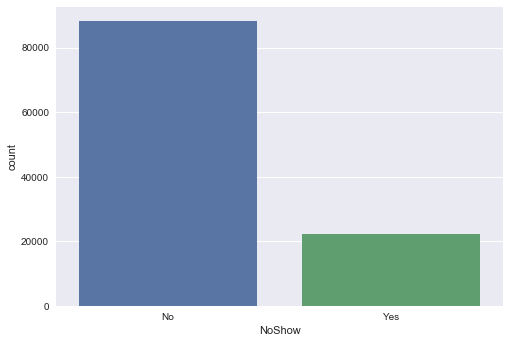

In [28]:
_ = sns.countplot(x=df.NoShow, data=df)

#### 5.1 Gender

- Below we can see that out of the 88,000 patients that have turned up, around 57,000 of them are Females and 31,000 are Males.
- Of the 22,500 patients that haven't come for the visit around 15,000 are Females and 7,500 are Males
- The ratio of Females to Males that have turned up looks simiar to those who haven't come for a visit.

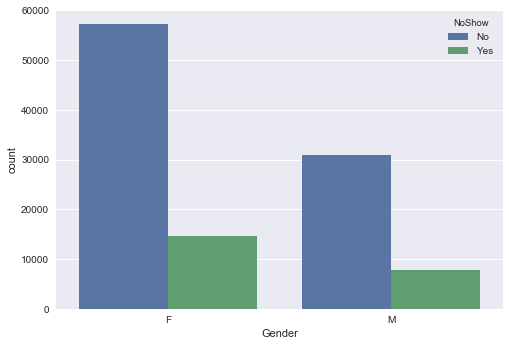

In [29]:
_ = sns.countplot(x=df.Gender, hue=df.NoShow, data=df)

#### 5.2 Age

We will draw a boxplot for the `Age` feature to check it's distribution.

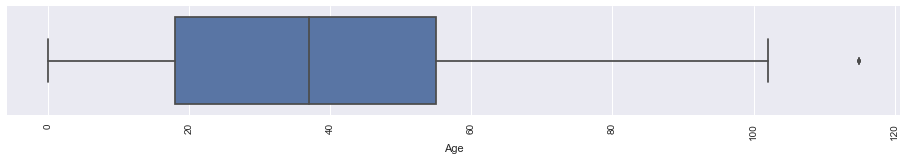

In [30]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
_ = sns.boxplot(x=df.Age)

From the above `BoxPlot` we can see that the Median Age is around 30 and the IQR is between 18 and 55.

Below we will plot the number of patients for different Age.

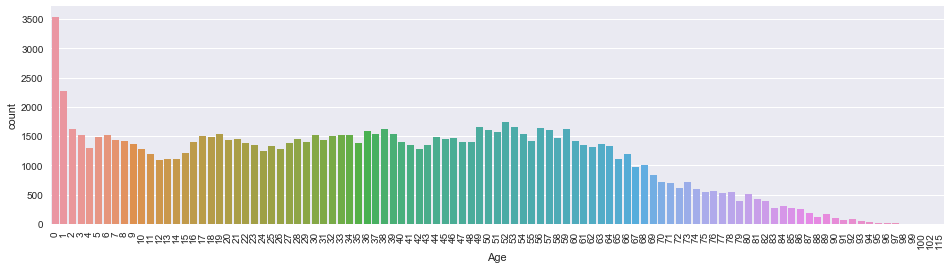

In [31]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=df.Age)

From the above Histogram we can see that there are peaks for the Infants and then the distribution starts to be uniform. Later, after the Age of around 60 we see a right-skewed distribution.

Below we will plot the Show/NoShow for the patients based on their Age.

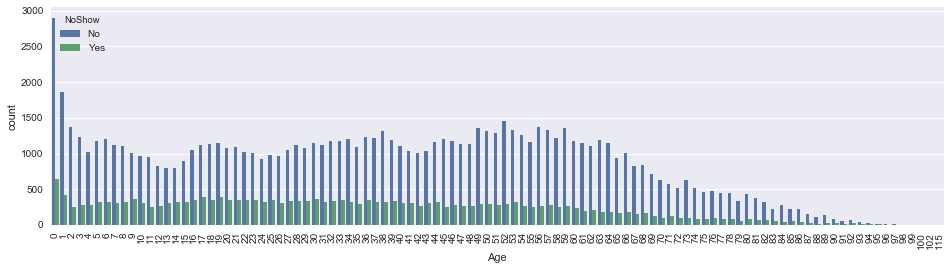

In [32]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=df.Age, hue=df.NoShow)

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Age's except for 'Age 0' and 'Age 1'. We will get a better clarity on the ratio of Show to NoShow for all Age's.

In [33]:
df_ratio = df[df.NoShow == 'No'].groupby(['Age']).size()/df.groupby(['Age']).size()

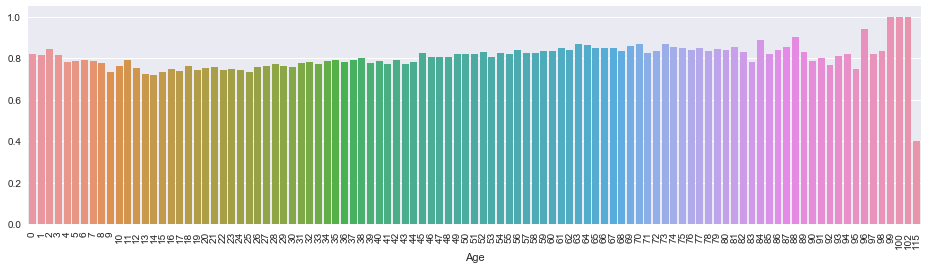

In [34]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_ratio.index, y=df_ratio)

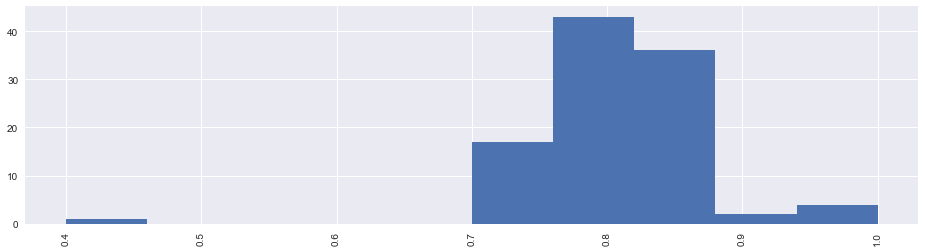

In [35]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = plt.hist(df_ratio)

#### 5.3 Neighbourhood

Below we will see the patients count for each Neighbourhood.

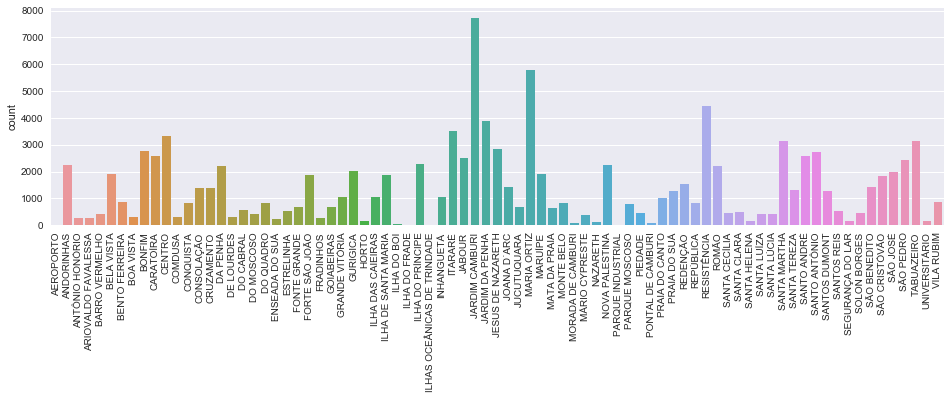

In [36]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=np.sort(df.Neighbourhood))

From the above visualization we can see that the number of patients for few Neighbourhood's is very high.

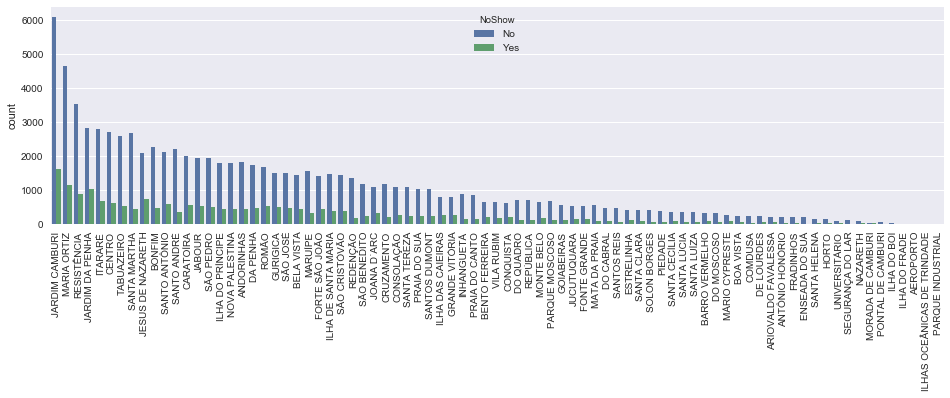

In [37]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.countplot(x=np.sort(df.Neighbourhood), hue=df.NoShow, order=df.Neighbourhood.value_counts().index)

From the above visualization looks like the ratio of Show to NoShow is almost the same for all Neighbourhood's. We will get a better clarity on the ratio of Show to NoShow for all Neighbourhood's in the below visualization.

In [38]:
df_n_ratio = df[df.NoShow == 'No'].groupby(['Neighbourhood']).size()/df.groupby(['Neighbourhood']).size()

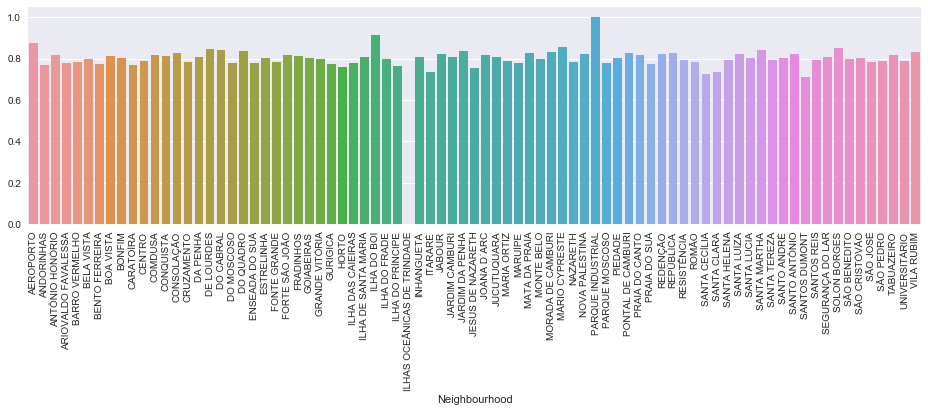

In [39]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_n_ratio.index, y=df_n_ratio)

#### 5.4 Scholarship

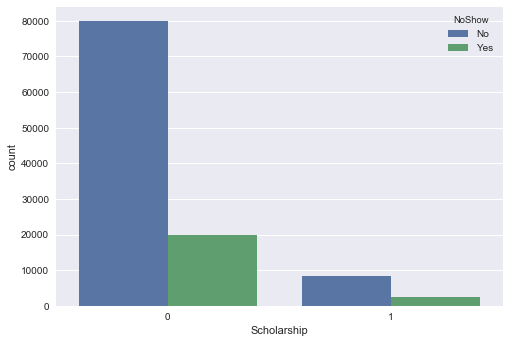

In [40]:
_ = sns.countplot(x=df.Scholarship, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 100,000 patients with Scholarship and out of them around 80% have come for the visit.
- Out of the 10,500 patients without Scholarship around 85% of them have come for the visit.

#### 5.5 Hypertension

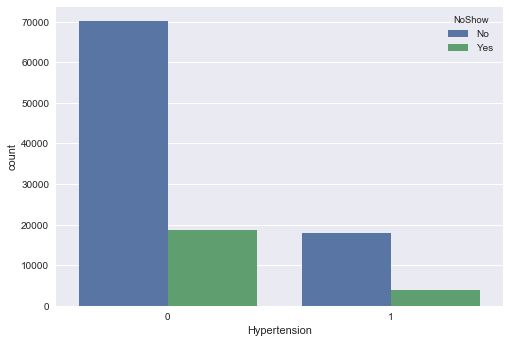

In [41]:
_ = sns.countplot(x=df.Hypertension, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 88,000 patients without Hypertension and out of them around 78% have come for the visit.
- Out of the 22,500 patients with Hypertension around 85% of them have come for the visit.

#### 5.6 Diabetes

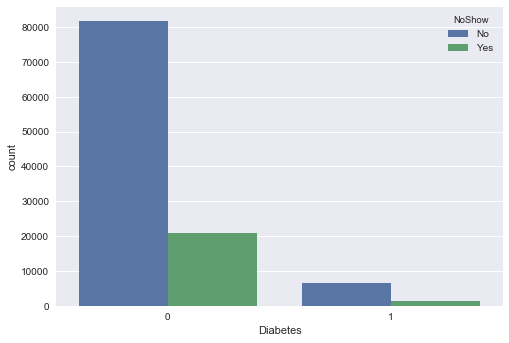

In [42]:
_ = sns.countplot(x=df.Diabetes, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 102,000 patients without Diabetes and out of them around 80% have come for the visit.
- Out of the 8,500 patients with Diabetes around 75% of them have come for the visit.

#### 5.7 Alcoholism

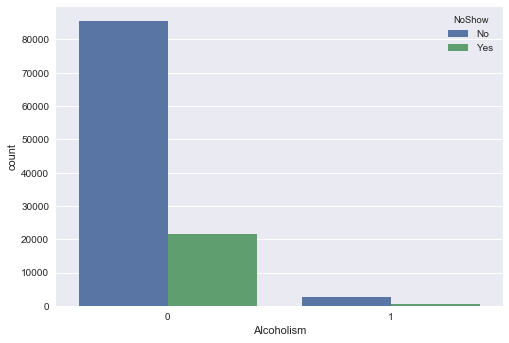

In [43]:
_ = sns.countplot(x=df.Alcoholism, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 105,000 patients without Alcoholism and out of them around 80% have come for the visit.
- Out of the 5,500 patients with Alcoholism around 90% of them have come for the visit.

#### 5.8 Handicap

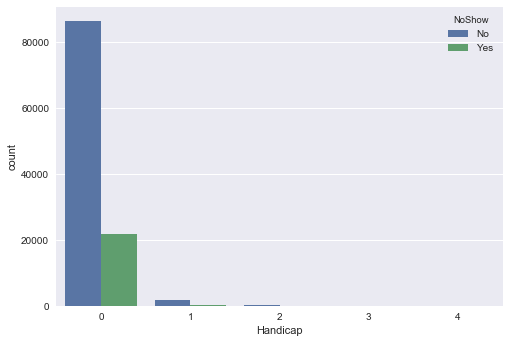

In [44]:
_ = sns.countplot(x=df.Handicap, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 110,000 patients without Handicap and out of them around 80% have come for the visit.

#### 5.9 SMSReceived

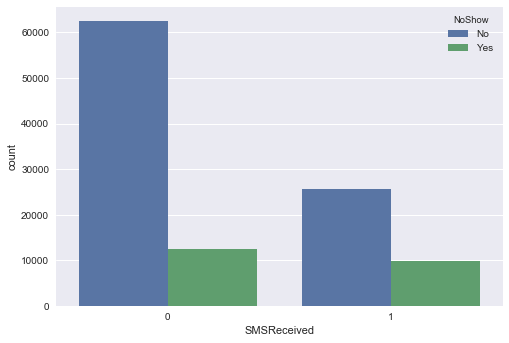

In [45]:
_ = sns.countplot(x=df.SMSReceived, hue=df.NoShow, data=df)

- From the above visualization we can see that there are around 75,000 patients who have not received SMS and out of them around 84% have come for the visit.
- Out of the 35,500 patients who have received SMS around 70% of them have come for the visit. (This looks opposite to what usually happens. People who do receive a reminder SMS usually tend to visit the hospital more than those who haven't received an SMS. Or this could be an SMS that was recived while booking an appointment and could possibly have no correlation with the visit probability.)

#### 5.10 ScheduledDay_DOW

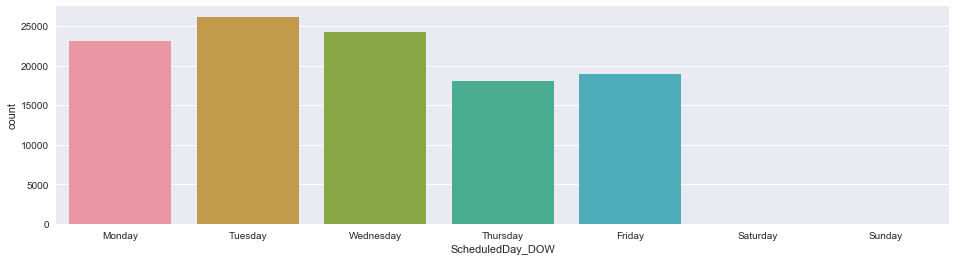

In [46]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.ScheduledDay_DOW, order=week_key)

- Looks like the call center that takes the appointments doesn't work over the weekends as we do not see any appointments taken on `Saturday` and `Sunday'.

#### 5.11 AppointmentDay_DOW

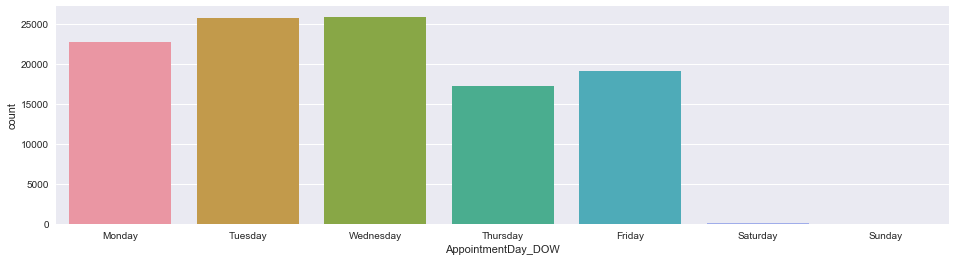

In [47]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.AppointmentDay_DOW, order=week_key)

- There looks like no pattern with the appointments from the above visualizations. But we can see there are very less appointments on `Saturday` and no appointments on `Sunday`.

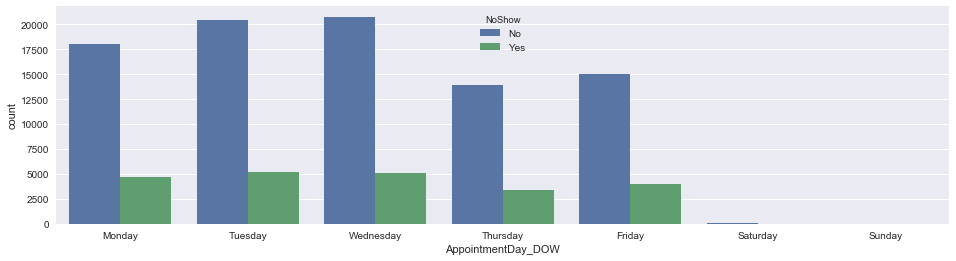

In [48]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.AppointmentDay_DOW, hue=df.NoShow, order=week_key)

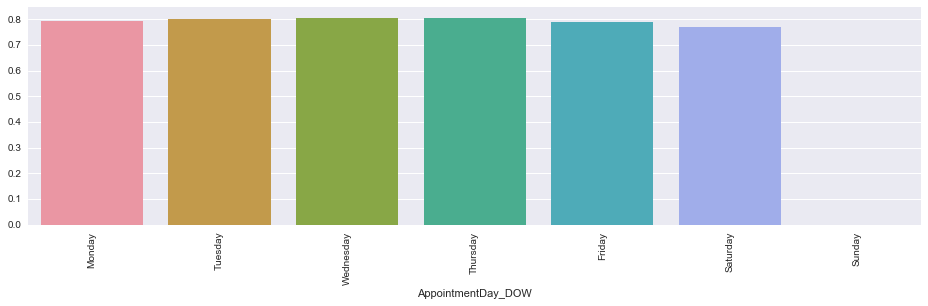

In [49]:
df_a_ratio = df[df.NoShow == 'No'].groupby(['AppointmentDay_DOW']).size()/df.groupby(['AppointmentDay_DOW']).size()
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
_ = sns.barplot(x=df_a_ratio.index, y=df_a_ratio, order=week_key)

- As we predicted earlier, we do not see any pattern in the patients visits based on the week day.

#### 5.12 Waiting_Time

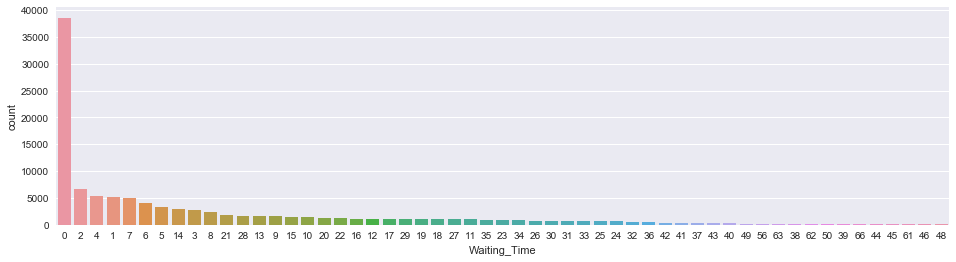

In [50]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time, order=df.Waiting_Time.value_counts().iloc[:55].index)

- From the above visualization we can see that most of the patients are booking their appointments on the same day.

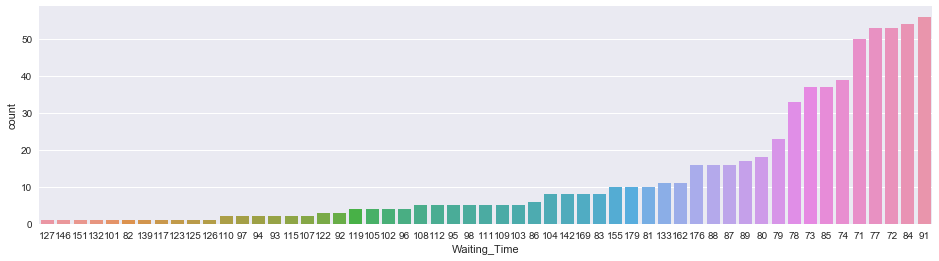

In [51]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time, order=df.Waiting_Time.value_counts(ascending=True).iloc[:55].index)

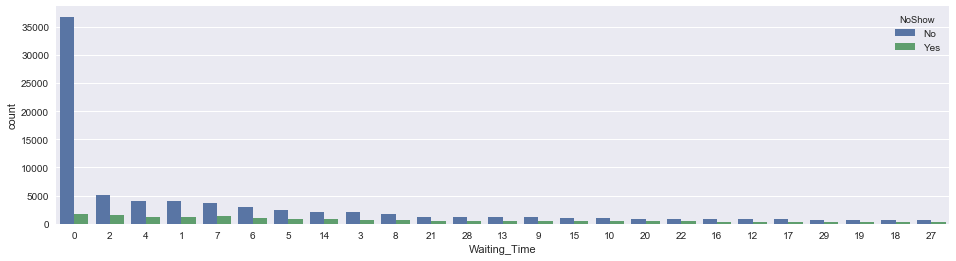

In [52]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time, hue=df.NoShow, order=df.Waiting_Time.value_counts().iloc[:25].index)

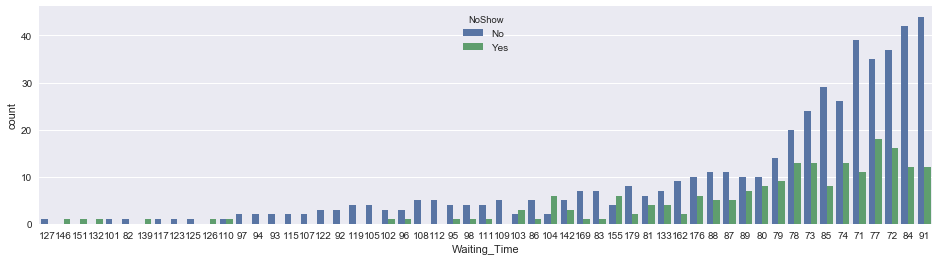

In [53]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df.Waiting_Time, hue=df.NoShow, order=df.Waiting_Time.value_counts(ascending=True).iloc[:55].index)

- Below we will visualize the last few rows (High WaitTime) for the Waiting_Time column.

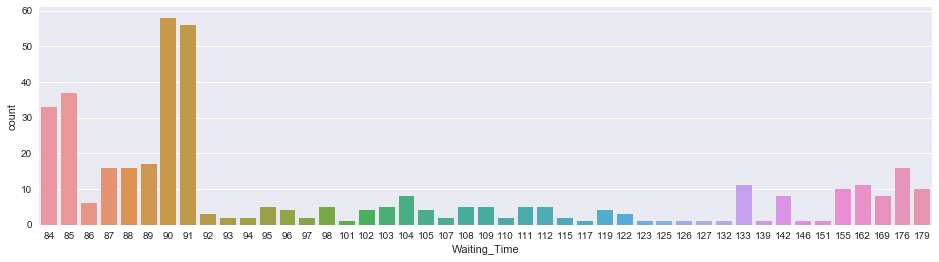

In [54]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df[['Waiting_Time']].sort_values('Waiting_Time', ascending=False).Waiting_Time.iloc[:400])

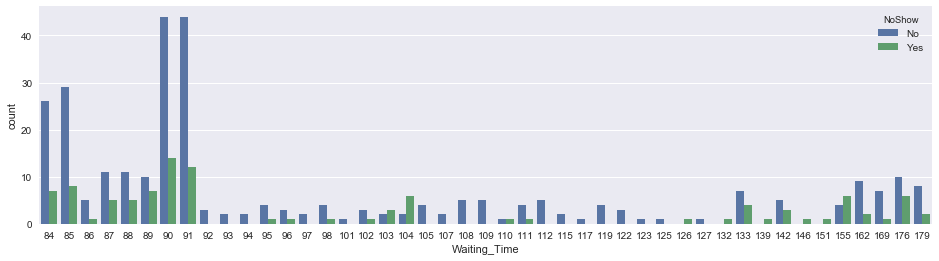

In [55]:
plt.figure(figsize=(16,4))
_ = sns.countplot(x=df[['Waiting_Time']].sort_values('Waiting_Time', ascending=False).Waiting_Time.iloc[:400], hue=df.NoShow)

### 6. Model Building

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110526 entries, 0 to 110526
Data columns (total 17 columns):
PatientId             110526 non-null int64
AppointmentID         110526 non-null int64
Gender                110526 non-null object
ScheduledDay          110526 non-null datetime64[ns]
AppointmentDay        110526 non-null datetime64[ns]
Age                   110526 non-null int64
Neighbourhood         110526 non-null object
Scholarship           110526 non-null object
Hypertension          110526 non-null object
Diabetes              110526 non-null object
Alcoholism            110526 non-null object
Handicap              110526 non-null object
SMSReceived           110526 non-null object
NoShow                110526 non-null object
ScheduledDay_DOW      110526 non-null object
AppointmentDay_DOW    110526 non-null object
Waiting_Time          110526 non-null int64
dtypes: datetime64[ns](2), int64(4), object(11)
memory usage: 20.2+ MB


In [57]:
# Use `LabelEncoder` to encode labels with value between 0 and n_classes-1.
#Gender
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
#Neighbourhood
le = LabelEncoder()
df['Neighbourhood'] = le.fit_transform(df['Neighbourhood'])
#ScheduledDay_DOW
le = LabelEncoder()
df['ScheduledDay_DOW'] = le.fit_transform(df['ScheduledDay_DOW'])
#AppointmentDay_DOW
le = LabelEncoder()
df['AppointmentDay_DOW'] = le.fit_transform(df['AppointmentDay_DOW'])
print("LabelEncoder Completed")

#NoShow
le = LabelEncoder()
df['NoShow'] = le.fit_transform(df['NoShow'])

LabelEncoder Completed


In [58]:
df['ScheduledDay_Y'] = df['ScheduledDay'].dt.year
df['ScheduledDay_M'] = df['ScheduledDay'].dt.month
df['ScheduledDay_D'] = df['ScheduledDay'].dt.day
df.drop(['ScheduledDay'], axis=1, inplace=True)

df['AppointmentDay_Y'] = df['AppointmentDay'].dt.year
df['AppointmentDay_M'] = df['AppointmentDay'].dt.month
df['AppointmentDay_D'] = df['AppointmentDay'].dt.day
df.drop(['AppointmentDay'], axis=1, inplace=True)

In [59]:
df.sample(n=10)

,PatientId,AppointmentID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,...,NoShow,ScheduledDay_DOW,AppointmentDay_DOW,Waiting_Time,ScheduledDay_Y,ScheduledDay_M,ScheduledDay_D,AppointmentDay_Y,AppointmentDay_M,AppointmentDay_D
11397,2938915638474,5608511,1,56,46,0,0,0,0,0,...,1,5,4,41,2016,4,20,2016,5,31
44109,587486915824,5679192,0,39,76,0,0,0,0,0,...,0,4,4,0,2016,5,10,2016,5,10
45474,8751879261162,5634457,0,7,78,0,0,0,0,0,...,1,3,4,5,2016,4,28,2016,5,3
90370,77727387868619,5655329,1,73,57,0,1,0,0,0,...,0,4,0,31,2016,5,3,2016,6,3
15863,9951352557398,5654292,0,41,33,0,0,0,0,0,...,0,4,0,10,2016,5,3,2016,5,13
84020,73436827644341,5741622,1,59,78,0,0,0,1,0,...,0,1,4,1,2016,5,30,2016,5,31
6077,5241177235994,5705970,1,3,56,0,0,0,0,0,...,0,4,3,2,2016,5,17,2016,5,19
49737,21541519359825,5662686,0,76,39,0,0,0,0,0,...,0,3,3,0,2016,5,5,2016,5,5
91884,59577488433571,5756774,1,63,50,0,1,0,0,0,...,0,5,5,0,2016,6,1,2016,6,1
108367,88163825426131,5761995,0,9,60,0,0,0,0,0,...,0,3,4,5,2016,6,2,2016,6,7


**From the basic EDA we see that there are around 80% of the patients who have turned up. We see a clear class imbalance problem here. A naive approach of predicting that every one shows up gives us an accuracy of 0.8. Below we shall see how well the classifiers score on this dataset.**

In [74]:
# Get the Dependent and Independent Features
X = df.drop(['NoShow'], axis=1)
y = df['NoShow']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

#### 6.1 DecisionTreeClassifier

In [76]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [77]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(dt_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

PatientId -- 0.20
AppointmentID -- 0.20
Gender -- 0.14
Age -- 0.13
Neighbourhood -- 0.12
Scholarship -- 0.05
Hypertension -- 0.03
Diabetes -- 0.03
Alcoholism -- 0.03
Handicap -- 0.02
SMSReceived -- 0.01
ScheduledDay_DOW -- 0.01
AppointmentDay_DOW -- 0.01
Waiting_Time -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.00
ScheduledDay_D -- 0.00
AppointmentDay_Y -- 0.00
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [78]:
dt_clf.score(X_test, y_test)

0.7239129242748259

#### 6.2 RandomForestClassifier

In [79]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [80]:
print("Feature Importance:\n")
for name, importance in zip(X.columns, np.sort(rf_clf.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

PatientId -- 0.19
AppointmentID -- 0.18
Gender -- 0.15
Age -- 0.14
Neighbourhood -- 0.11
Scholarship -- 0.05
Hypertension -- 0.04
Diabetes -- 0.03
Alcoholism -- 0.03
Handicap -- 0.02
SMSReceived -- 0.01
ScheduledDay_DOW -- 0.01
AppointmentDay_DOW -- 0.01
Waiting_Time -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


In [81]:
rf_clf.score(X_test, y_test)

0.79220814827000052

#### 6.3 GridSearchCV

In [72]:
params={'n_estimators':[10,20], 'max_depth':[None, 5], 'min_samples_split':[2,3]}
rf_clf = RandomForestClassifier(random_state=0)
clf_grid = GridSearchCV(rf_clf, params, cv=5, n_jobs=-1, verbose=1)
clf_grid.fit(X, y)
print(clf_grid.best_params_)
print(clf_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   21.4s finished


{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 10}
0.798065613521


From the above Model Score we can see that we are doing almost similar to the naive predictor. Also, as we have imbalanced classes, we should ideally use different metrics rather than `Accuracy`.

#### 6.4 RandomForestClassifier - 2

Below, we will build a RandomForestClassifier on the data by removing 'PatientId' and 'AppointmentID' as these features are just some random numbers and shouldn't be included while making a decision.

In [86]:
# Get the Dependent and Independent Features
X_df = df.drop(['NoShow', 'PatientId', 'AppointmentID'], axis=1)
y_df = df['NoShow']

In [89]:
rf_clf_new = RandomForestClassifier(random_state=0)
rf_clf_new.fit(X_df, y_df)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [90]:
print("Feature Importance:\n")
for name, importance in zip(X_df.columns, np.sort(rf_clf_new.feature_importances_)[::-1]):
    print("{} -- {:.2f}".format(name, importance))

Feature Importance:

Gender -- 0.31
Age -- 0.27
Neighbourhood -- 0.12
Scholarship -- 0.06
Hypertension -- 0.05
Diabetes -- 0.04
Alcoholism -- 0.04
Handicap -- 0.03
SMSReceived -- 0.03
ScheduledDay_DOW -- 0.02
AppointmentDay_DOW -- 0.01
Waiting_Time -- 0.01
ScheduledDay_Y -- 0.01
ScheduledDay_M -- 0.01
ScheduledDay_D -- 0.01
AppointmentDay_Y -- 0.01
AppointmentDay_M -- 0.00
AppointmentDay_D -- 0.00


#### 6.3 GridSearchCV

In [94]:
params={'n_estimators':[10,15], 'max_depth':[None, 3], 'min_samples_split':[2,3]}
rf_clf_new = RandomForestClassifier(random_state=0)
clf_grid_new = GridSearchCV(rf_clf_new, params, cv=5, n_jobs=-1, verbose=1)
clf_grid_new.fit(X_df, y_df)
print(clf_grid_new.best_params_)
print(clf_grid_new.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   14.8s finished


{'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 10}
0.798065613521


#### 7. Conclusion

From the above feature importance, we could see that `Gender`, `Age`, `Neighbourhood`, `Scholarship` and `Hypertension` are some of the top features that would help us determine if the patient who has taken an appointment will Show/NoShow.